## Analysis VCoG Files

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from omegaconf import OmegaConf
import json
# -------------------------------------------------
# LOAD CONFIG
# -------------------------------------------------
config_path = "config.yaml"
config = OmegaConf.load(config_path)
folder_path = Path(config.renamed_output_path)


json_path = Path(config.json_path)
# Output directory
output_dir = Path(config.output_dir)
output_dir.mkdir(parents=True, exist_ok=True)
# -------------------------------------------------

# -------------------------------------------------
# FIND ALL VCOG FILES
# -------------------------------------------------
vcog_files = list(folder_path.glob("*VCoG*.csv"))
print(f"🔍 Found {len(vcog_files)} VCOG files")

for i, file in enumerate(vcog_files, 1):
    #print(f"⚙ loading → {file.name}")
    df = pd.read_csv(file)
    globals()[f"df{i}_VC"] = df
    print(f"✅ loaded → {file.name} with name df{i}_VC")

# -------------------------------------------------
# FIND ALL CCOG FILES
# -------------------------------------------------
ccog_files = list(folder_path.glob("*CCoG*.csv"))
print(f"🔍 Found {len(ccog_files)} CCOG files")

for i, file in enumerate(ccog_files, 1):
    #print(f"⚙ loading → {file.name}")
    df = pd.read_csv(file)
    globals()[f"df{i}_CC"] = df
    print(f"✅ loaded → {file.name} with name df{i}_CC")


🔍 Found 5 VCOG files
✅ loaded → Exp_1_VCoG_TOC_renamed.csv with name df1_VC
✅ loaded → Exp_2_VCoG_TOC_EW_renamed.csv with name df2_VC
✅ loaded → Exp_3_VCoG_2m_OL_Ncable_WE_renamed.csv with name df3_VC
✅ loaded → Exp_4_VCoG_4m_OL_Ncable_EW_renamed.csv with name df4_VC
✅ loaded → Exp_5_VCoG_6m_OL_Ncable_WE_renamed.csv with name df5_VC
🔍 Found 5 CCOG files
✅ loaded → Exp_1_CCoG_TOC_renamed.csv with name df1_CC
✅ loaded → Exp_2_CCoG_TOC_EW_renamed.csv with name df2_CC
✅ loaded → Exp_3_CCoG_2m_OL_Ncable_WE_renamed.csv with name df3_CC
✅ loaded → Exp_4_CCoG_4m_OL_Ncable_EW_renamed.csv with name df4_CC
✅ loaded → Exp_5_CCoG_6m_OL_Ncable_WE_renamed.csv with name df5_CC


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Optional, for nicer plots

def generate_performance_report(df_vcog, df_ccog , target_offset=2.0):

    # Extract Columns
    # VCOG: Time (0), Cart_X (2), Cart_Y (3), Cable_Lock (9)
    # CCOG: Cable_X (2), Cable_Y (3)
    time = df_vcog.iloc[:, 0].values
    cart_pos = df_vcog.iloc[:, [2, 3]].values
    cable_lock = df_vcog.iloc[:, 9].values
    bad_cable_pos = df_ccog.iloc[:, [2, 3]].values
    
    # --- 1. Geometric Correction ---
    print("Applying Geometric Fix (180-degree logic)...")
    # Vector from Cart to Bad Cable
    offset_vector_bad = bad_cable_pos - cart_pos
    # Corrected Vector (Inverse)
    offset_vector_good = -1 * offset_vector_bad
    # True Cable Position
    true_cable_pos = cart_pos + offset_vector_good
    
    # --- 2. Calculate Performance Metrics ---
    
    # A. Accuracy (Bias Analysis)
    # Calculate the Euclidean distance for every point
    measured_offsets = np.linalg.norm(true_cable_pos - cart_pos, axis=1)
    mean_offset = np.mean(measured_offsets)
    bias = mean_offset - target_offset
    
    # B. Precision (Stability Analysis)
    std_dev = np.std(measured_offsets)
    
    # C. Reliability (Lock Consistency)
    # Count how many data points have Lock = 1
    lock_count = np.sum(cable_lock == 1)
    total_count = len(cable_lock)
    reliability_pct = (lock_count / total_count) * 100
    
    # --- 3. Print the Report ---
    print("\n" + "="*40)
    print("   ALGORITHM PERFORMANCE REPORT")
    print("="*40)
    print(f"Target Offset:       {target_offset:.2f} m")
    print(f"Mean Measured:       {mean_offset:.2f} m")
    print(f"Systematic Bias:     {bias*100:.2f} cm  <-- (Accuracy)")
    print(f"Standard Deviation:  {std_dev*100:.2f} cm  <-- (Jitter/Precision)")
    print(f"Lock Reliability:    {reliability_pct:.1f}%     <-- (Robustness)")
    print("="*40)
    
    # --- 4. Visualizations ---
    plt.figure(figsize=(14, 6))
    
    # Plot A: Offset Distance Over Time (Stability)
    plt.subplot(1, 2, 1)
    # Normalize time to start at 0
    t_norm = time - time[0]
    plt.plot(t_norm, measured_offsets, label='Measured Offset', color='#4C72B0', linewidth=1)
    plt.axhline(y=target_offset, color='r', linestyle='--', label=f'Target ({target_offset}m)')
    plt.axhline(y=mean_offset, color='g', linestyle='-', label=f'Mean ({mean_offset:.2f}m)')
    plt.title(f'Tracking Stability (Exp 3: {target_offset}m Offset)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Distance from Cart to Cable (m)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot B: Error Distribution (Histogram)
    plt.subplot(1, 2, 2)
    sns.histplot(measured_offsets, kde=True, color='#55A868', bins=30)
    plt.axvline(x=target_offset, color='r', linestyle='--', label='Target')
    plt.axvline(x=mean_offset, color='k', linestyle='-', label='Mean')
    plt.title('Distribution of Offset Errors')
    plt.xlabel('Calculated Offset Distance (m)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



--- Loading Data ---
Applying Geometric Fix (180-degree logic)...

   ALGORITHM PERFORMANCE REPORT
Target Offset:       2.00 m
Mean Measured:       2.08 m
Systematic Bias:     7.64 cm  <-- (Accuracy)
Standard Deviation:  21.03 cm  <-- (Jitter/Precision)
Lock Reliability:    99.4%     <-- (Robustness)


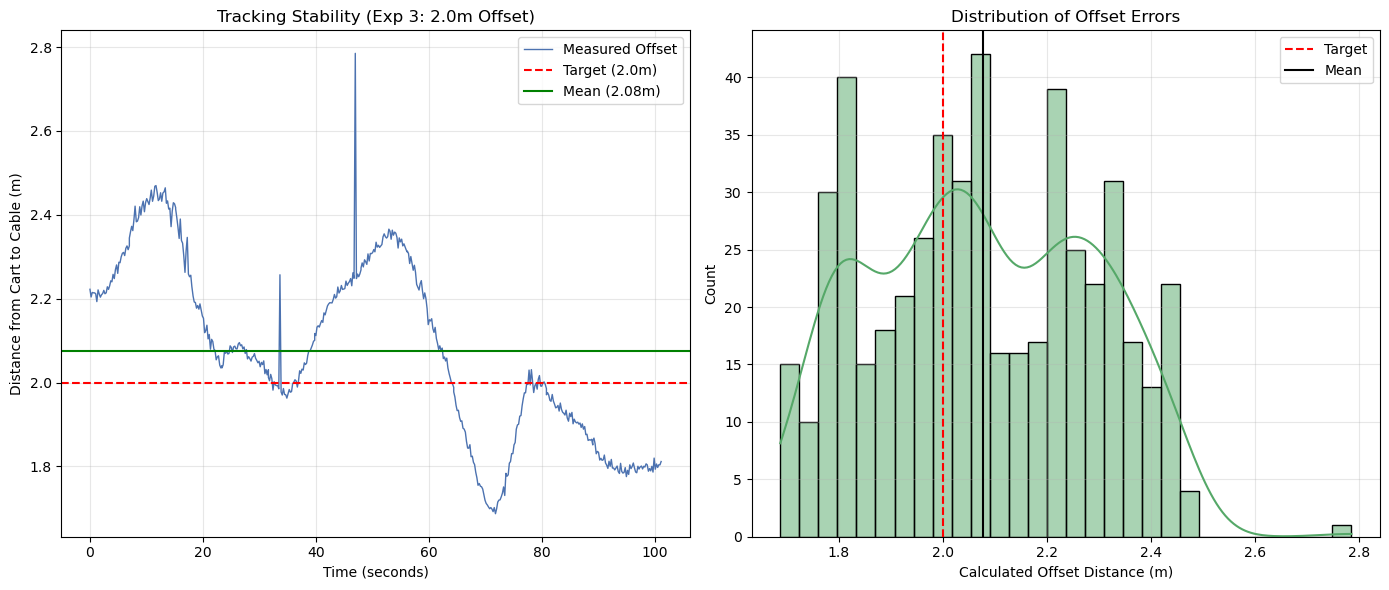

In [47]:
# --- Execute ---
df_vcog = df3_VC  # Experiment 3 VCoG
df_ccog = df3_CC  # Experiment 3 CCoG

generate_performance_report(df_vcog, df_ccog, target_offset=2.0)

--- Loading Data ---
Applying Geometric Fix (180-degree logic)...

   ALGORITHM PERFORMANCE REPORT
Target Offset:       4.00 m
Mean Measured:       3.83 m
Systematic Bias:     -17.24 cm  <-- (Accuracy)
Standard Deviation:  40.26 cm  <-- (Jitter/Precision)
Lock Reliability:    100.0%     <-- (Robustness)


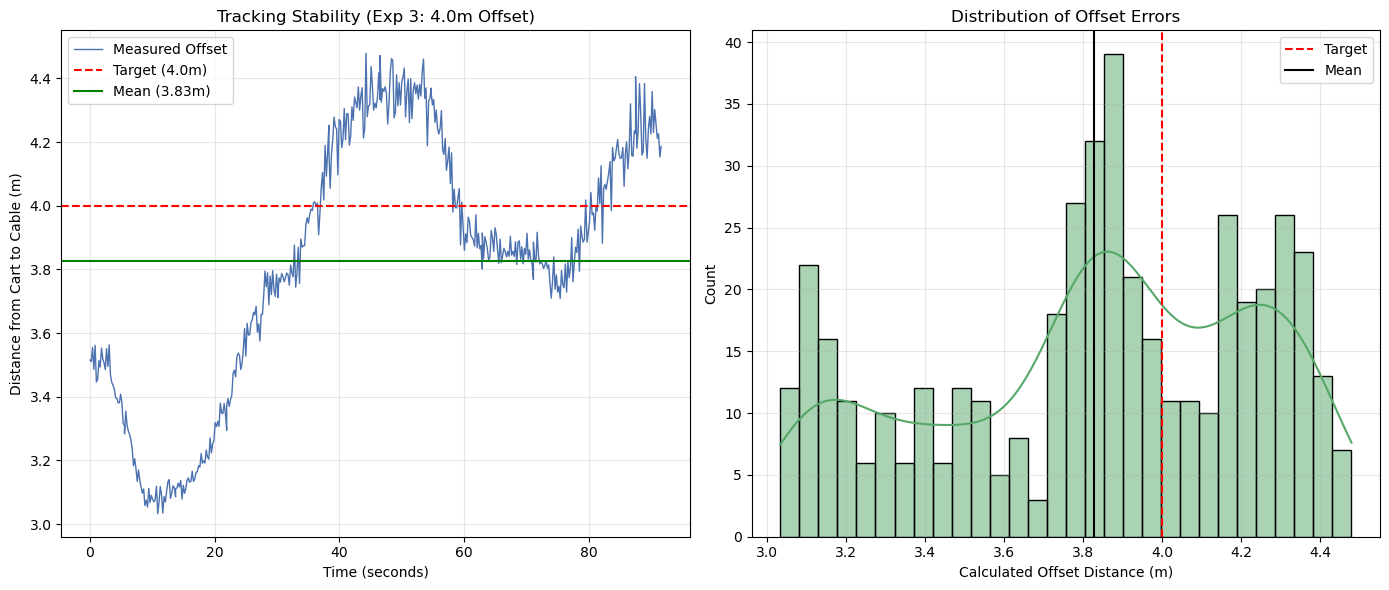

In [48]:
# --- Execute ---
# Update these paths to your local file locations
df_vcog = df4_VC
df_ccog = df4_CC

generate_performance_report(df_vcog, df_ccog, target_offset=4.0)

--- Loading Data ---
Applying Geometric Fix (180-degree logic)...

   ALGORITHM PERFORMANCE REPORT
Target Offset:       0.00 m
Mean Measured:       0.12 m
Systematic Bias:     11.84 cm  <-- (Accuracy)
Standard Deviation:  4.59 cm  <-- (Jitter/Precision)
Lock Reliability:    100.0%     <-- (Robustness)


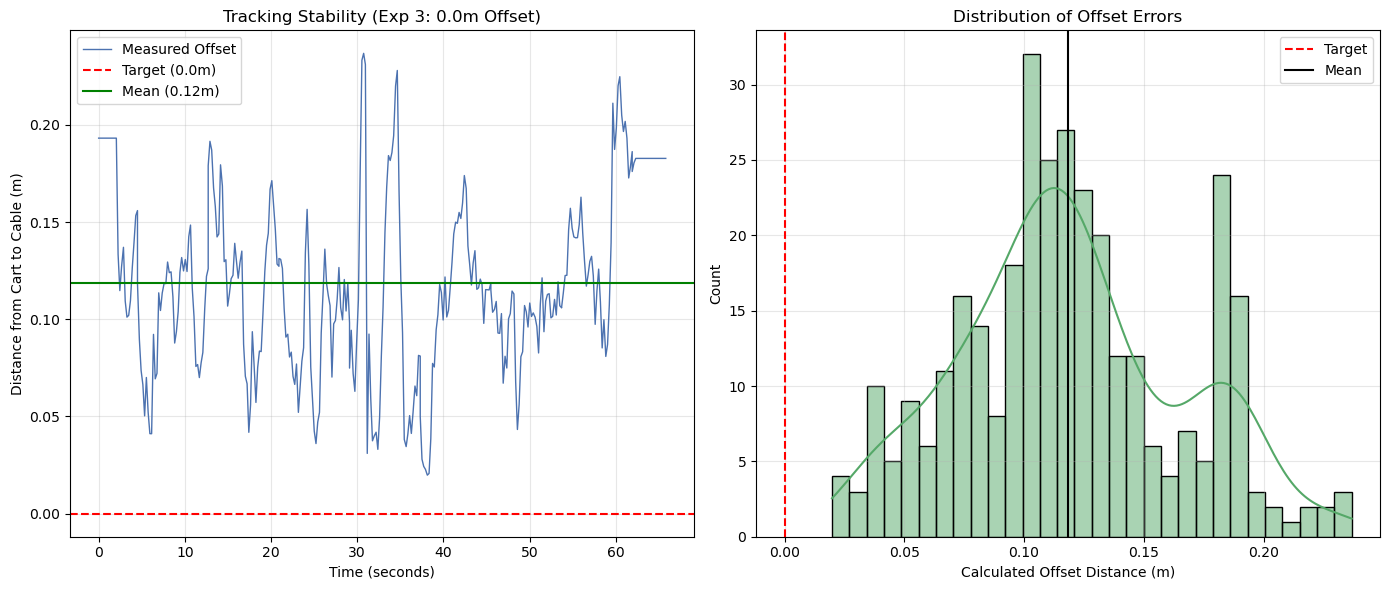

In [49]:
# --- Execute ---
# Update these paths to your local file locations
df_vcog = df2_VC
df_ccog = df2_CC

generate_performance_report(df_vcog, df_ccog, target_offset=0.0)

--- Loading Data ---
Applying Geometric Fix (180-degree logic)...

   ALGORITHM PERFORMANCE REPORT
Target Offset:       0.00 m
Mean Measured:       0.27 m
Systematic Bias:     26.56 cm  <-- (Accuracy)
Standard Deviation:  64.19 cm  <-- (Jitter/Precision)
Lock Reliability:    98.8%     <-- (Robustness)


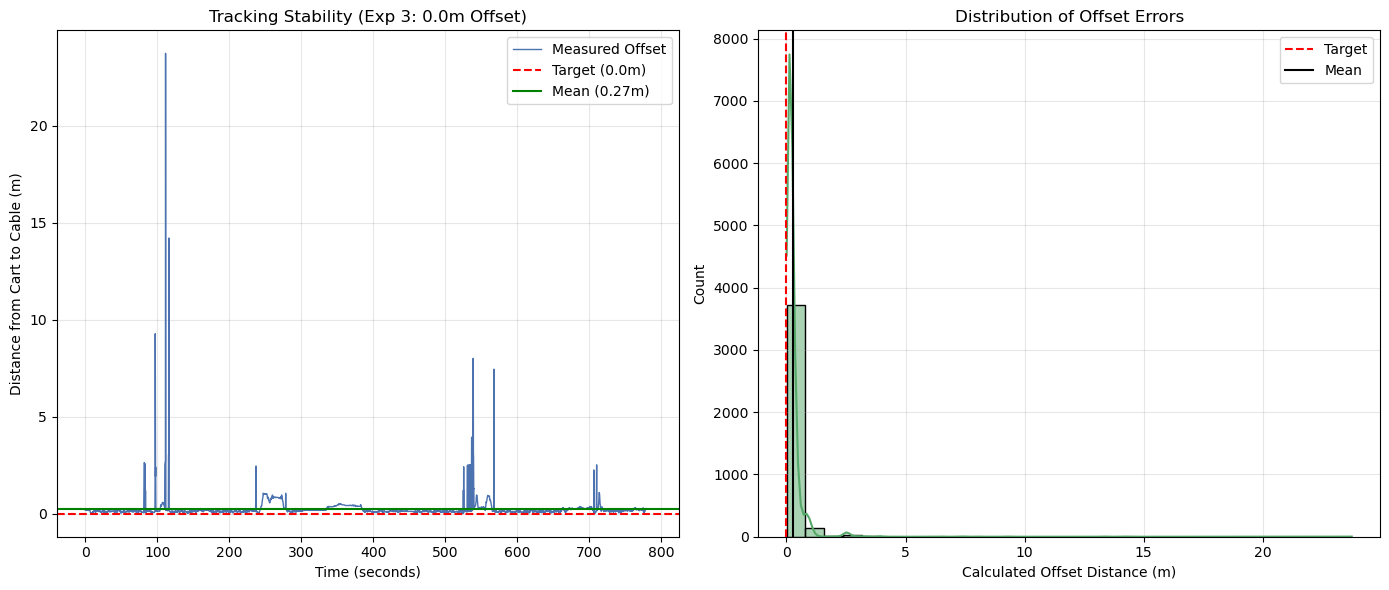

In [50]:
# --- Execute ---
# Update these paths to your local file locations
df_vcog = df1_VC
df_ccog = df1_CC

generate_performance_report(df_vcog, df_ccog, target_offset=.0)